In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.title_fontsize'] = 0
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def Portfolio(df,char,numStocks,threshold,cost=0,kind='long') :
    target_pct = 1/numStocks
    rebal_pct = 4*target_pct
    rebalto_pct = 2*target_pct
    d = df[['date','ticker','ret']].copy()
    if kind=='long' :
        d['rnk'] = df.groupby('date')[char].rank(ascending=False).values
    else :
        d['rnk'] = df.groupby('date')[char].rank().values
    filtr1 = d.rnk<=numStocks
    filtr2 = d.rnk<=threshold
    dates = np.sort(d.date.unique())
    start = dates[0]
    accum = pd.Series(dtype=float,index=dates)
    accum.name = 'accum'
    accum.index.name = 'date'
    accum[start] = 1
    ticksOld = d[filtr1 & (d.date==start)].ticker.to_list()
    old = pd.DataFrame(ticksOld,columns=['ticker'])
    old['date'] = start
    old['before'] = 0
    old['after'] = target_pct
    old = old.set_index('ticker')
    old['withret'] = old.after * (1+d.set_index(['date','ticker']).loc[start].ret)
    old['rnk'] = d.set_index(['date','ticker']).loc[start].rnk
    out = old.copy().reset_index()
    for yesterday, today in zip(dates[:-1],dates[1:]) :
        new = pd.DataFrame(ticksOld,columns=['ticker'])
        new = new.set_index('ticker')
        new['before'] = old.withret
        accum[today] = new.before.sum()
        target = accum[today]*target_pct
        rebal = accum[today]*rebal_pct
        rebalto = accum[today]*rebalto_pct
        ticks2 = d[filtr2 & (d.date==today)].ticker.to_list()
        ticksKeep = [t for t in ticksOld if t in ticks2]
        ticksDrop = [t for t in ticksOld if t not in ticks2] 
        cash = np.sum( np.where(new.loc[ticksKeep,'before']>rebal,\
                               new.loc[ticksKeep,'before']-rebalto,0) ) 
        cash += new.loc[ticksDrop,'before'].sum()
        cash *= (1-cost)
        new['after'] = 0
        new.loc[ticksKeep,'after'] = np.where((new.loc[ticksKeep,'before']>rebal),rebalto,\
                                               new.loc[ticksKeep,'before'])
        ticksSorted = d[d.date==today].sort_values(by='rnk').ticker.to_list()
        ticksOld = ticksKeep.copy()
        while cash > 0 :
            t = ticksSorted.pop(0)
            if t in ticksKeep :
                before = new.loc[t,'after']
            else :
                before = 0
                ticksOld.append(t)
            new.loc[t,'after'] = max(before, min(before+cash,target))
            cash -= ( new.loc[t,'after'] - before )
        new['before'] = new.before.fillna(0)
        new['withret'] = new.after * (1+d.set_index(['date','ticker']).loc[today].ret)
        new['rnk'] = d.set_index(['date','ticker']).loc[today].rnk
        new['date'] = today
        out = pd.concat((out,new.reset_index()))
        old = new.loc[ticksOld]
    out = out.merge(accum,on='date',how='left')
    out['trade$'] = out.after-out.before
    out['trade%'] = out['trade$'] / out.accum
    out['weight'] = out.after / out.accum
    return out, accum.pct_change().shift(-1)

def plotMV(sds,mns) :
    plt.scatter(sds,mns,color='blue',s=50)
    for name in mns.index :
        sd = sds[name]
        mn = mns[name]
        plt.annotate(text=name,xy=(sd,mn),textcoords="offset points",xytext=(0,-16),ha='center')     
    plt.xlabel('Standard Deviation (%)')
    plt.ylabel('Mean Excess Return (%)')
       
def tangency(rprem,cov) :
    w = np.linalg.solve(cov,rprem)
    return pd.Series(w/np.sum(w), index=rprem.index)

def minvar(rprem,cov) :
    w = np.linalg.solve(cov,np.ones(len(rprem)))
    return pd.Series(w/np.sum(w), index=rprem.index)

def plot_bullet(mns,cov) :
    sds = pd.Series(np.sqrt(np.diag(cov)),index=cov.index)
    plotMV(sds,mns)
    tang = tangency(mns,cov)
    gmv = minvar(mns,cov)
    
    # decide how far to the right to draw the bullet
    A = mns @ np.linalg.solve(cov,mns)
    w = np.linalg.solve(cov,np.ones(len(mns)))
    B = mns @ w
    C = np.sum(w)
    maxvar = (sds.max())**2
    k = A - maxvar*(A*C-B**2)
    mu = (B+np.sqrt(B**2-C*k)) / C
    x = mns@tang
    y = mns@gmv
    if np.abs(x-y) < 1.0e-8 :
        return None
    else :
        b = (mu - mns@gmv) / (x-y)
        # calculate and plot bullet
        ports = [a*tang + (1-a)*gmv for a in np.linspace(-b,b,100)]
        rprem = pd.Series([w@mns for w in ports])
        stdevs = pd.Series([np.sqrt(w@cov@w) for w in ports])
        plt.plot(stdevs,rprem,color='green',label='Markowitz Bullet')
            
def plot_frontier(mns,cov) :
    sds = pd.Series(np.sqrt(np.diag(cov)),index=cov.index)
    plotMV(sds,mns)
    tang = tangency(mns,cov)
    mn = tang @ mns
    sd = np.sqrt(tang @ cov @ tang)
    plt.scatter(sd,mn,s=300,label='Tangency',marker='*',color='black')
    plt.annotate(text='Tang',xy=(sd,mn),textcoords="offset points",xytext=(-20,8),ha='center')   
    grid = np.linspace(0,np.max(sds),100)
    plt.plot(grid,(mn/sd)*grid,color='red',label='Frontier')

## Overview

In portfolios.ipynb, we set numStocks, and then each month we dropped all stocks that had moved out of the desired (best or worst) group of size numStocks.  We replaced the dropped stocks with the new stocks that entered the desired group.  We also rebalanced all positions back to size 1/numStocks.  That was a lot of trading.

In this notebook, we set numStocks and also a threshold.  We only drop stocks when they move beyond the threshold.  For example, we might set numStocks = 40 and threshold = 300.  Then, when we have a position in a stock, we maintain a position in it until it moves beyond 500 in our rankings.  So, we will always have stocks in the top 300 but not necessarily the top 40.  Also, instead of rebalancing to 1/numStocks = 2.5%, we allow positions to grow to 4/numStocks = 10% before we rebalance.  When we do rebalance, we prune the position down to 2/numStocks = 5%.  

When we drop stocks or prune positions, we generate cash.  We assume a transaction cost in buying and selling, so the new shares we buy can only total (1-cost) x cash.  For example, cost = 0.005 for a 1/2% round-trip cost (bid-ask spread).  We allocate the cash based on our current ranking: starting with the most desired stock, we add it to the portfolio at weight 1/numStocks if it was not in the portfolio, or we buy new shares to bring the weight up to 1/numStocks if the weight was less than that, or we leave the position alone if it is above 1/numStocks but below the threshold 4/numStocks.  We then move on to the next stock in the rankings and continue until we run out of cash.  

As a result of this protocol, the number of stocks in the portfolio will fluctuate some over time, being around but not necessarily equal to numStocks (except at the very beginning).

Portfolio columns are as follows:

* before = \$ investment at beginning of month before trading
* after = \$ investment at beginning of month after trading
* accum = portfolio value at beginning of month
* trade\\$ = trade in \$
* trade% = trade as percent of portfolio value
* weight = investment at beginnig of month after trading as % of portfolio value
* withret = \$ value at end of month (including monthly return) -> 'before' for next month
* rnk = rank based on characteristic or prediction, 1 = best for high portfolio, 1 = worst for low portfolio (so we always want rnk=1,2,... in portfolio)

## Read data

In [2]:
df = pd.read_csv('predictionsRuss2000.csv')
df['date'] = pd.to_datetime(df.date).dt.to_period('M')
df = df.dropna(subset=['predict'])

## Get SPY for comparison

In [3]:
rets = pdr(['SPY','IWM','IEF'],'yahoo',start='2002-12-01')
rets = rets['Adj Close'].resample('M').last().pct_change().dropna()
rets.index = rets.index.to_period('M')
rets.columns = [x.lower() for x in rets.columns]
rets.index.name = 'date'

In [4]:
spy = pdr('SPY','yahoo',start='2002-12-01')
spyRets = spy['Adj Close'].resample('M').last().pct_change().dropna()
spyRets.index = spyRets.index.to_period('M')
spyRets.index.name = 'date'

iwm = pdr('IWM','yahoo',start='2002-12-01')
iwmRets = iwm['Adj Close'].resample('M').last().pct_change().dropna()
iwmRets.index = iwmRets.index.to_period('M')
iwmRets.index.name = 'date'

## Form portfolios from predictions

In [5]:
lowPort, lowRets = Portfolio(df,'predict', numStocks=40, threshold=300, cost=0.005,  kind='short')
highPort, highRets = Portfolio(df,'predict', numStocks=40, threshold=300, cost=0.005,kind='long')

rets['low'] = lowRets
rets['high'] = highRets
rets = rets.dropna()
rets *= 100

In [6]:
(12*rets.mean()).round(1)

spy     11.2
iwm     10.5
ief      4.2
low    -26.7
high    11.3
dtype: float64


Combo portfolio is

spy     0.45
iwm     0.60
ief     0.63
low    -0.94
high    0.14
dtype: float64 

Mean is 40.8 % and std dev is 15.7 %

Correlation matrix of returns:



,spy,iwm,ief,low,high
spy,1.00,0.90,-0.29,0.70,0.86
iwm,0.90,1.00,-0.37,0.77,0.93
ief,-0.29,-0.37,1.00,-0.31,-0.40
low,0.70,0.77,-0.31,1.00,0.73
high,0.86,0.93,-0.40,0.73,1.00


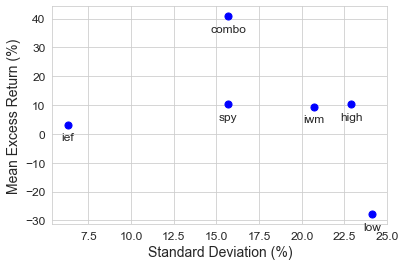

In [7]:
rf = 1 # %
cov = 12*rets.cov()
mns = 12*rets.mean()
sds = np.sqrt(12)*rets.std()
plotMV(sds,mns-rf)

# tangency portfolio
tang = tangency(mns-rf,cov)
mn = tang @ mns
sd = np.sqrt(tang@cov@tang)

# find multiple/fraction of tangency portfolio with same risk as SPY
scale = sds['spy'] / sd
p = scale*tang
mnp = p @ mns
sdp = np.sqrt(p@cov@p)
plt.scatter(sdp,mnp,color='blue',s=50)
plt.annotate(text='combo',xy=(sdp,mnp),textcoords="offset points",xytext=(0,-16),ha='center')     
plt.savefig('low_high_mv.pdf')
print('\nCombo portfolio is\n')
print(p.round(2),'\n')
print('Mean is',round(mnp,1),'% and std dev is',round(sdp,1),'%\n')
print('Correlation matrix of returns:\n')
rets.corr().round(2)

## Turnover

In [8]:
turnover = pd.DataFrame(dtype=float, index=np.sort(df.date.unique()), columns=['high','low'])
turnover['high'] = 100*highPort.groupby('date')['trade%'].apply(lambda x: x.abs().sum()).iloc[1:] / 2
turnover['low'] = 100*lowPort.groupby('date')['trade%'].apply(lambda x: x.abs().sum()).iloc[1:] / 2
print('\nMonthly Portfolio Turnover (%)\n')
turnover.round(1)


Monthly Portfolio Turnover (%)



,high,low
2008-01,NaN,NaN
2008-02,24.3,12.8
2008-03,36.5,5.9
2008-04,28.9,23.2
2008-05,54.0,8.4
...,...,...
2021-10,59.2,22.8
2021-11,69.8,28.0
2021-12,66.2,28.4
2022-01,78.3,20.6


In [9]:
print('\nAverage Monthly Portfolio Turnover (%)\n')
turnover.mean().round(1)


Average Monthly Portfolio Turnover (%)



high    59.8
low     15.6
dtype: float64

## Number of stocks

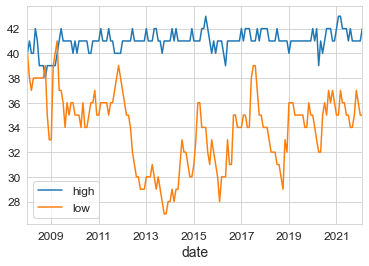

In [10]:
highPort.groupby('date').apply(lambda d: d[d.weight!=0].weight.count()).plot(label='high')
lowPort.groupby('date').apply(lambda d: d[d.weight!=0].weight.count()).plot(label='low')
nothing = plt.legend()

## Distribution of allocations (weights)

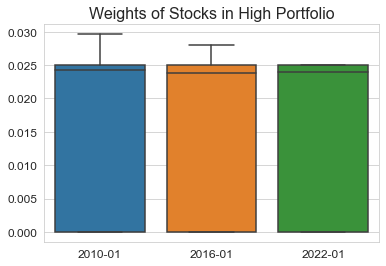

In [11]:
examples = ['2010-01','2016-01','2022-01']
weights = [highPort[highPort.date==date].weight for date in examples]
weights = pd.concat(weights,axis=1)
weights.columns = examples
sns.boxplot(data=weights)
nothing=plt.title('Weights of Stocks in High Portfolio')

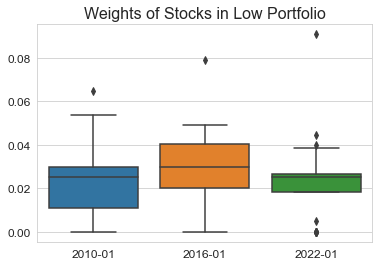

In [12]:
examples = ['2010-01','2016-01','2022-01']
weights = [lowPort[lowPort.date==date].weight for date in examples]
weights = pd.concat(weights,axis=1)
weights.columns = examples
sns.boxplot(data=weights)
nothing=plt.title('Weights of Stocks in Low Portfolio')

## Distribution of ranks

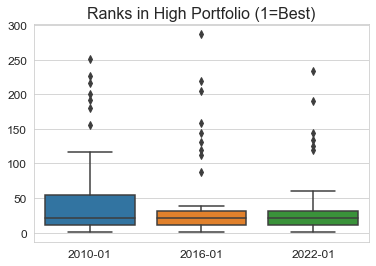

In [13]:
examples = ['2010-01','2016-01','2022-01']
ranks = [highPort[(highPort.date==date)&(highPort.after!=0)].rnk for date in examples]
ranks = pd.concat(ranks,axis=1)
ranks.columns = examples
sns.boxplot(data=ranks)
nothing=plt.title('Ranks in High Portfolio (1=Best)')

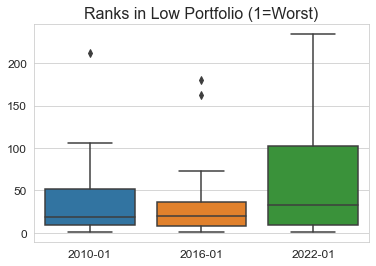

In [14]:
examples = ['2010-01','2016-01','2022-01']
ranks = [lowPort[(lowPort.date==date)&(lowPort.after!=0)].rnk for date in examples]
ranks = pd.concat(ranks,axis=1)
ranks.columns = examples
sns.boxplot(data=ranks)
nothing=plt.title('Ranks in Low Portfolio (1=Worst)')